# Agent Observability with Langfuse Tracing

This notebook demonstrates how to capture traces of AI agents using **Langfuse** for observability and tracing and how to read a trace.

1. **Langfuse Setup** - Installing and configuring Langfuse for tracing
2. **Agent Implementation** - Building a simple agent
3. **Automatic Trace Capture** - Capture a trace with callback handler.
4. **Collect and read a trace** - Collect and read a trace.
5. **Manual Trace Capture** - Capture a trace manually and how to read it

## Why Agent Observability?

Before adding complexity to your agent architecture, validate whether additional components are truly needed.

**The process:**
- Capture agent traces to understand current behavior
- Define a test set covering desired use cases
- Run evaluations against the agent
- Measure trajectory accuracy and response quality

This data-driven approach ensures you only add complexity when justified by actual performance gaps.

## 1. Setup & Installation

### Install Required Packages

In [ ]:
# Install required packages
!pip install -q langfuse langchain langgraph langchain_ibm pandas python-dotenv matplotlib seaborn rich
!pip install -q "git+https://github.com/ibm-granite-community/utils.git"

### Import Dependencies

In [ ]:
import os
import uuid
import json
from typing import Optional
import requests
import seaborn as sns
from IPython.display import Image, display
from typing import Any
from typing import Annotated, TypedDict
from ibm_granite_community.notebook_utils import get_env_var
from langchain_core.utils.utils import convert_to_secret_str
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.graph.state import CompiledStateGraph
from langgraph.prebuilt import ToolNode
from langfuse import Langfuse
from langfuse import Evaluation
from langfuse.langchain import CallbackHandler
from langfuse import get_client
from langfuse.api.resources.commons.types.trace_with_full_details import TraceWithFullDetails
from rich import print

model = "ibm/granite-4-h-small"

model_parameters = {
    "temperature": 0,
    "max_completion_tokens": 200,
    "repetition_penalty": 1.05,
}

### Langfuse Setup

Langfuse can be deployed either locally (self-hosted) or on the cloud:

**Self-hosted (local):**

Follow the Docker Compose deployment [guide](https://langfuse.com/self-hosting/deployment/docker-compose)

**Cloud:**

Sign up for [cloud account](https://us.cloud.langfuse.com/)

### Configuration

1. Create a new project
2. Navigate to Settings → API Keys
3. Create new API keys and copy:
   * Public Key
   * Secret Key
   * Host URL

### Configure watsonx.ai

You'll need the following environment variables for watsonx.ai:
- `WATSONX_URL`: Your watsonx.ai endpoint URL
- `WATSONX_APIKEY`: Your watsonx.ai API key
- `WATSONX_PROJECT_ID`: Your watsonx.ai project ID

Set these in a `.env` file or export them as environment variables.

### Initialize Langfuse Client

In [ ]:
LANGFUSE_PUBLIC_KEY=convert_to_secret_str(get_env_var("LANGFUSE_PUBLIC_KEY", "unset"))
LANGFUSE_SECRET_KEY=convert_to_secret_str(get_env_var("LANGFUSE_SECRET_KEY", "unset"))
LANGFUSE_HOST=convert_to_secret_str(get_env_var("LANGFUSE_HOST", "unset"))

In [ ]:
langfuse_client = Langfuse(
    public_key=os.environ['LANGFUSE_PUBLIC_KEY'],
    secret_key=os.environ['LANGFUSE_SECRET_KEY'],
    host=os.environ['LANGFUSE_HOST']
)

## 2. Agent Implementation

### Build a Minimal Function Calling Agent

Create the FC agent using LangChain's `create_agent` from [Function_Calling](https://github.com/ibm-granite-community/granite-agent-cookbook/blob/main/recipes/Function_Calling/Function_Calling_Agent.ipynb) recipe

In [ ]:
AV_STOCK_API_KEY = convert_to_secret_str(get_env_var("AV_STOCK_API_KEY", "unset"))

WEATHER_API_KEY = convert_to_secret_str(get_env_var("WEATHER_API_KEY", "unset"))

llm = init_chat_model(
    model=model,
    model_provider="ibm",
    url=convert_to_secret_str(get_env_var("WATSONX_URL")),
    apikey=convert_to_secret_str(get_env_var("WATSONX_APIKEY")),
    project_id=get_env_var("WATSONX_PROJECT_ID"),
    params=model_parameters,
)

class State(TypedDict, total=False):
    messages: Annotated[list[AnyMessage], add_messages]

def get_stock_price(ticker: str, date: str) -> dict:
    """
    Retrieves the lowest and highest stock prices for a given ticker and date.

    Args:
        ticker: The stock ticker symbol, for example, "IBM".
        date: The date in "YYYY-MM-DD" format for which you want to get stock prices.

    Returns:
        A dictionary containing the low and high stock prices on the given date.
    """
    print(f"Getting stock price for {ticker} on {date}")

    apikey = AV_STOCK_API_KEY.get_secret_value()
    if apikey == "unset":
        print("No API key present; using a fixed, predetermined value for demonstration purposes")
        return {
            "low": "245.4500",
            "high": "249.0300"
        }

    try:
        stock_url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker}&apikey={apikey}"
        stock_data = requests.get(stock_url)
        data = stock_data.json()
        stock_low = data["Time Series (Daily)"][date]["3. low"]
        stock_high = data["Time Series (Daily)"][date]["2. high"]
        return {
            "low": stock_low,
            "high": stock_high
        }
    except Exception as e:
        print(f"Error fetching stock data: {e}")
        return {
            "low": "$245.45",
            "high": "$249.03"
        }


def get_current_weather(location: str) -> dict:
    """
    Fetches the current weather for a given location (default: San Francisco).

    Args:
        location: The name of the city for which to retrieve the weather information.

    Returns:
        A dictionary containing weather information such as temperature in celsius, weather description, and humidity.
    """
    print(f"Getting current weather for {location}")
    apikey=WEATHER_API_KEY.get_secret_value()
    if apikey == "unset":
        print("No API key present; using a fixed, predetermined value for demonstration purposes")
        return {
            "description": "thunderstorms",
            "temperature": 25.3,
            "humidity": 94
        }

    try:
        # API request to fetch weather data
        weather_url = f"https://api.openweathermap.org/data/2.5/weather?q={location}&appid={apikey}&units=metric"
        weather_data = requests.get(weather_url)
        data = weather_data.json()
        # Extracting relevant weather details
        weather_description = data["weather"][0]["description"]
        temperature = data["main"]["temp"]
        humidity = data["main"]["humidity"]

        # Returning weather details
        return {
            "description": weather_description,
            "temperature": temperature,
            "humidity": humidity
        }
    except Exception as e:
        print(f"Error fetching weather data: {e}")
        return {
            "description": "none",
            "temperature": "none",
            "humidity": "none"
        }


def route_tools(state: State) -> str:
    """
    This is conditional_edge function to route to the ToolNode if the last message
    in the state has tool calls. Otherwise, route to the END node to complete the
    workflow.
    """
    messages = state.get("messages")
    if not messages:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    last_message = messages[-1]
    # If the last message is from the model and it contains a tool call request
    if isinstance(last_message, AIMessage) and len(last_message.tool_calls) > 0:
        return "tools"
    return END


def llm_node(state: State) -> State:
    messages = state["messages"]
    response_message = llm_with_tools.invoke(messages)
    state_update = State(messages=[response_message])
    return state_update

### Build graph

In [ ]:
tools = [get_stock_price, get_current_weather]
llm_with_tools = llm.bind_tools(tools)
tool_node = ToolNode(tools=tools)

graph_builder = StateGraph(State)
graph_builder.add_node("llm", llm_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge(START, "llm")
graph_builder.add_conditional_edges(
    "llm",
    route_tools,
    {
        "tools": "tools",
        END: END,
    },
)
graph_builder.add_edge("tools", "llm")


graph: CompiledStateGraph[State] = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

def function_calling_agent(graph: CompiledStateGraph, user_input: str):
    user_message = HumanMessage(user_input)
    print(user_message.pretty_repr())
    input = State(messages=[user_message])
    for event in graph.stream(input):
        for value in event.values():
            print(value["messages"][-1].pretty_repr())

### Run the Agent

In [ ]:
function_calling_agent(graph, "What is the weather in Miami?")

### Create a Langfuse experiment to evaluate the agent output

### How an experiment Works

1. Create dataset items with inputs and expected outputs
2. Define your task function to test
3. Write evaluators to score results
4. Run experiment to get automated scores across all test cases

| Component | Description | Example |
|-----------|-------------|---------|
| **Dataset** | Collection of test cases | defined as `local_data` in this notebook with stock price questions |
| **Dataset Item** | Single test case with input and optional expected output | `{"input": "What were...", "expected_output": "On September..."}` |
| **Task** | Application code being tested | `agent_execution_to_evaluate()` - executes your agent |
| **Evaluator** | Function that scores outputs | `accuracy_evaluator()` - checks if expected output appears in response |
| **Score** | Evaluation result (numeric/categorical/boolean) | `1.0` (correct) or `0.0` (incorrect) |
| **Experiment Run** | Execution of task on all dataset items | `langfuse_client.run_experiment()` |

In [ ]:
def agent_execution_to_evaluate(*, item, **kwargs):
    user_message = HumanMessage(item["input"])
    response = graph.invoke( {"messages": [user_message]})
    return response.get('messages')[-1].content
    
local_data = [
    {
    "input": "What were the IBM stock prices on September 5, 2025?", 
    "expected_output": "On September 5, 2025, the stock price of IBM ranged from a low of $245.45 to a high of $249.03."
    },
]

# Define evaluation functions
def accuracy_evaluator(*, input, output, expected_output, metadata, **kwargs):
    if expected_output and expected_output.lower() in output.lower():
        return Evaluation(name="accuracy", value=1.0, comment="Correct answer found")

    return Evaluation(name="accuracy", value=0.0, comment="Incorrect answer")


def length_evaluator(*, input, output, **kwargs):
    return Evaluation(name="response_length", value=len(output), comment=f"Response has {len(output)} characters")
    
result = langfuse_client.run_experiment(
    name="Stock Market Quizz",
    description="Testing basic functionality",
    data=local_data,
    task=agent_execution_to_evaluate,
    evaluators=[accuracy_evaluator, length_evaluator]
)

### Review the experiment in Langfuse UI

After running the experiment, you can view the results in the Langfuse dashboard.

In the above example our experiment tracked two key metrics:

**Accuracy**: Whether the model's response contained the expected stock price information

**Response Length**: The character count of each response, helping assess verbosity

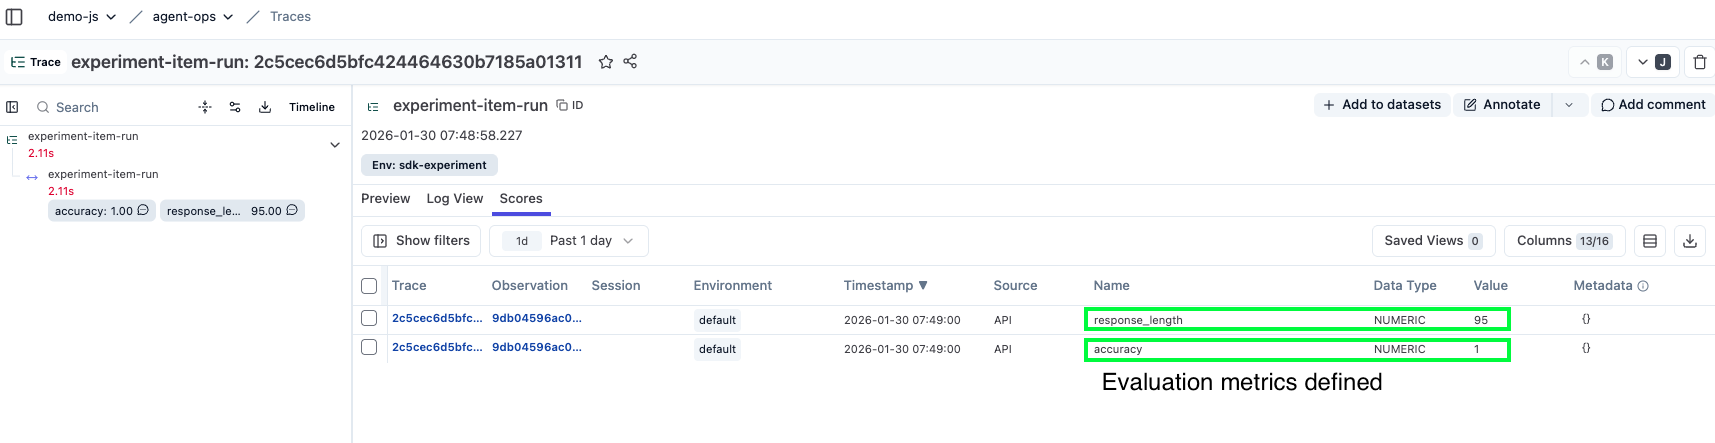

## 3. Send an Automatic Trace to Langfuse

### What is a trace ?

A Langfuse trace represents a single request or operation in your AI application.

It captures the entire lifecycle of an execution, from the initial input to the final output, along with all intermediate steps and metadata.

### Observations

Each trace contains multiple observations that log individual steps of execution.
Observations provide granular visibility into what happens during a request, enabling detailed debugging and performance optimization.

They automatically nest through OpenTelemetry context propagation - each new observation becomes a child of the currently active one.

### Observation Types

| Type | Purpose |
|------|---------|
| **event** | Discrete point-in-time occurrences |
| **span** | Operations with duration |
| **generation** | AI model calls (prompts, tokens, costs) |
| **agent** | LLM-guided application flow decisions |
| **tool** | External API/service calls |
| **chain** | Links between application steps |
| **retriever** | Data retrieval (vector stores, databases) |
| **evaluator** | Assessment of LLM output quality |
| **embedding** | Embedding generation with metrics |
| **guardrail** | Protection against malicious content |


### Using CallbackHandler for simplicity

In [ ]:
langfuse_handler = CallbackHandler()

In [ ]:
user_input = "What is the weather in Miami?"
config = {"callbacks": [langfuse_handler]}
input_state = State(messages=[user_input])

In [ ]:
result = graph.invoke(input_state, config=config)
print(result.get('messages')[-1].content)

### Review Langfuse automatic trace in Langfuse UI

LangChain's hierarchical execution naturally maps to Langfuse's trace structure:

- Runnable.invoke() creates a TRACE
- Nested chains/agents create child CHAIN
- LLM calls create GENERATION observations
- Tool calls create TOOL observations

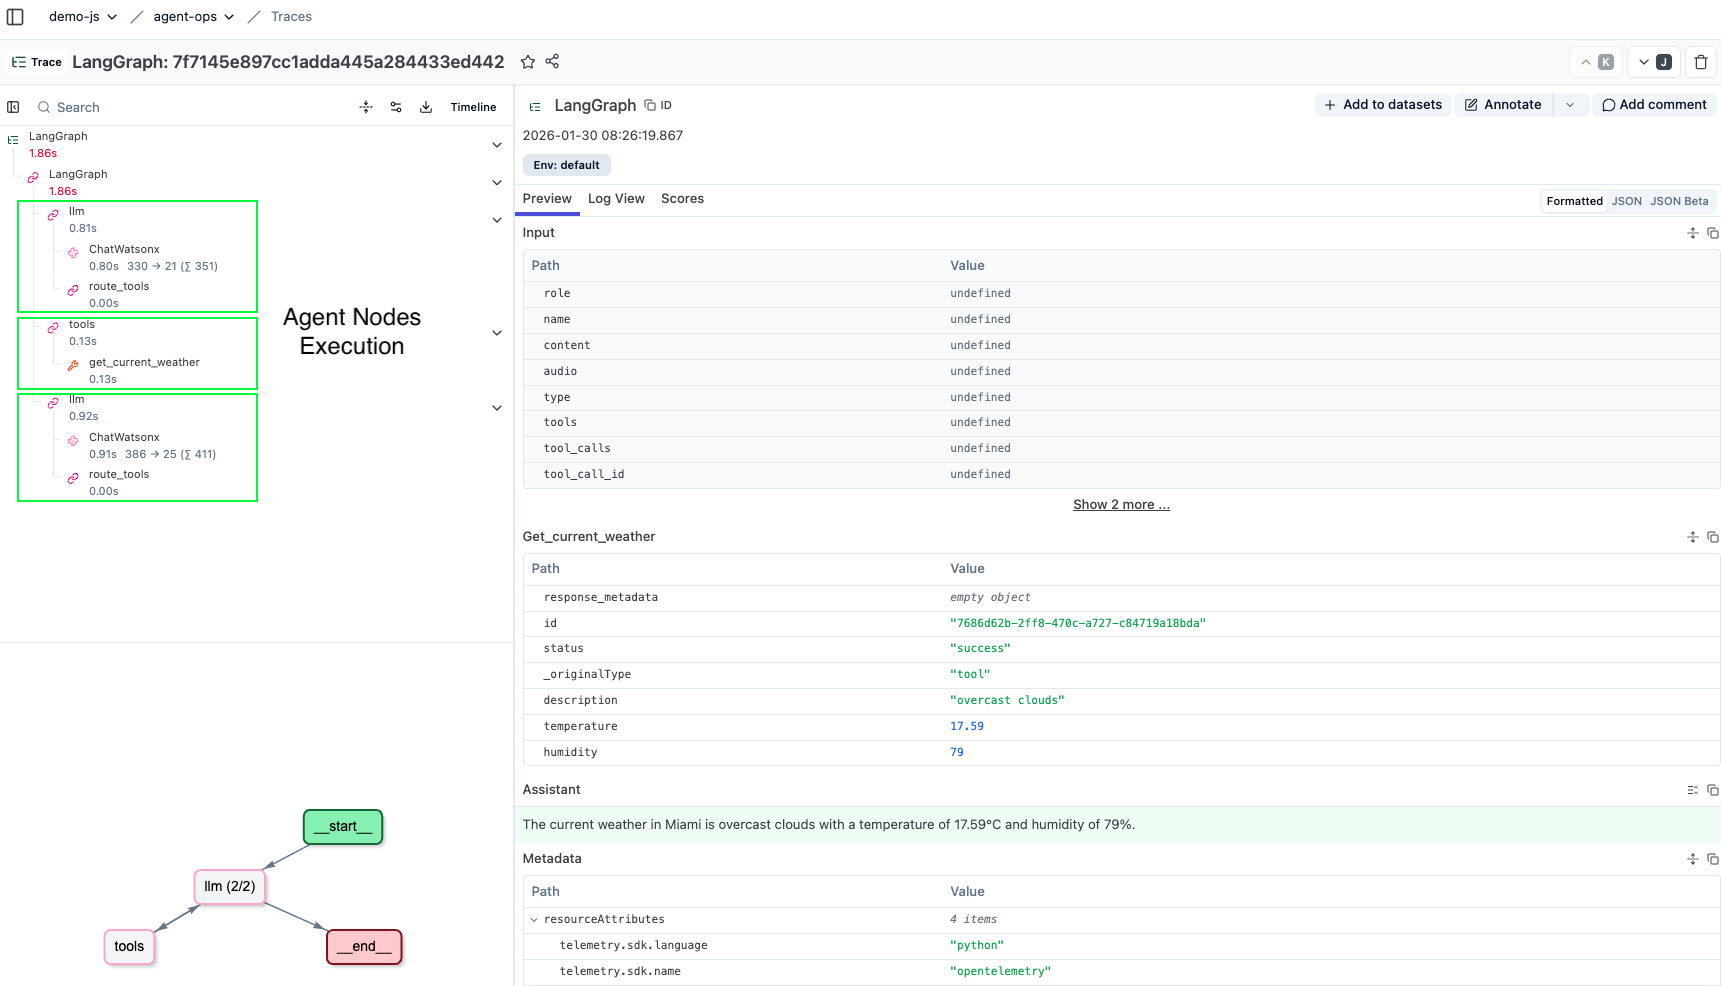

## 4. Collect and Read a Langfuse Trace

In [ ]:
def save_as_json(data, output_filename="output.json"):
    print("saving")
    with open(output_filename, 'w', encoding='utf-8') as f:
        f.write(data.json(indent=4))  

def extract(trace_id):
    langfuse = get_client()
    trace = langfuse.api.trace.get(trace_id=trace_id)
    trace_dict = trace.dict()
    
    # Exclude ChannelWrite observations. 
    # If ChannelWrite are desired, simply set "exclude_channel_write = False" bellow
    
    # Information : ChannelWrite nodes are used internally by LangGraph to 
    #               manage the flow of information and updates between different 
    #               nodes or agents within a graph
    
    exclude_channel_write = True
    
    if exclude_channel_write:
        _observation = []
        for observation in trace.observations:
            if "ChannelWrite" not in observation.name:
                _observation.append(observation)
        
        trace_dict['observations'] = [_observation[0]]
        trace = TraceWithFullDetails(
            **trace_dict
        )

    save_as_json(trace, f"./trace.json")

Obtain the **trace_id** of the last agent execution :

In [ ]:
trace_id = langfuse_handler.last_trace_id
print(f"Last trace ID: {trace_id}")

In [ ]:
try:
    print(f"Extracting for trace {trace_id}")
    extract(trace_id)
except Exception as e:
    print(str(e))

In [ ]:
with open('trace.json') as f:
    trace_json = json.load(f)

### Reading a Langfuse Trace as JSON

Here are a few tips and tricks to explore your trace data if you have extracted it as a JSON file.

#### Understanding the Trace Structure

A Langfuse trace JSON contains several key sections:

##### 1. **Top-Level Trace Information**
- `id`: Unique identifier for the trace
- `name`: Name of the traced operation (e.g., "LangGraph")
- `timestamp`: When the trace was created
- `latency`: Total execution time in seconds

##### 2. **Input and Output (Messages)**

The trace's `input` and `output` fields contain the conversation flow:

**Input** (`trace.input`):
```json
{
  "messages": [
    "What is the weather in Miami?"
  ]
}
```
This represents the initial user query.

**Output** (`trace.output`):
```json
{
  "messages": [
    {...},  // Human message
    {...},  // AI message with tool call
    {...},  // Tool response
    {...}   // Final AI response
  ]
}
```

The output contains a **list of messages** representing the complete conversation flow:

1. **Human Message** (`type: "human"`):
   - Contains the user's question
   - Has a unique `id` for reference

2. **AI Message with Tool Call** (`type: "ai"`):
   - The model's decision to use a tool
   - `tool_calls`: Array of tools the model wants to invoke
   - `response_metadata`: Contains token usage and model information
   - Example:
     ```json
     "tool_calls": [
       {
         "name": "get_current_weather",
         "args": {"location": "Miami"},
         "id": "chatcmpl-tool-ca1b90c760644de4a5221c48c3c19605"
       }
     ]
     ```

3. **Tool Message** (`type: "tool"`):
   - Contains the tool's execution result
   - `content`: The actual data returned by the tool
   - `tool_call_id`: Links back to the tool call that triggered it
   - Example:
     ```json
     {
       "content": "{\\"description\\": \\"few clouds\\", \\"temperature\\": 12.98, \\"humidity\\": 41}",
       "type": "tool",
       "name": "get_current_weather",
       "tool_call_id": "chatcmpl-tool-ca1b90c760644de4a5221c48c3c19605"
     }
     ```
     To find the output of a tool_call execution, locate the observation who's output message has a tool_call_id equal to the id value of the tool_call you are interested in.


4. **Final AI Message** (`type: "ai"`):
   - The model's final response using the tool results
   - `content`: Human-readable answer
   - `finish_reason: "stop"`: Indicates completion

##### 3. **Observations**

The `observations` array (`trace.observations`) contains detailed execution steps:

- **Types**: `GENERATION`, `SPAN`, `CHAIN`, `EVENT`
- **Key Fields**:
  - `name`: Operation name (e.g., "route_tools", "llm")
  - `input`: Data sent to this step
  - `output`: Data returned from this step
  - `metadata`: Additional context (LangGraph step info, node names, etc.)
  - `startTime` / `endTime`: Timing information
  - `parentObservationId`: Links to parent observation for hierarchy

#### Reading the Message Flow

To understand the execution flow:

1. Start with `trace.input.messages` for the initial query
2. Follow `trace.output.messages` sequentially to see:
   - User question → AI tool call → Tool execution → AI final answer
3. Cross-reference with `trace.observations` for detailed execution metadata
4. Match tool calls using `tool_call_id` to link requests and responses


In [ ]:
def extract_tool_calls(trace_data):
    """
    Extract tool calls and their corresponding results from a Langfuse trace.
    
    Tool calls are found in AI messages that have a non-empty 'tool_calls' list.
    Tool call results are matched by tool_call_id, searching first in the trace
    output messages, then falling back to the observations.
    
    Returns a list of dicts with keys: name, args, tool_call_id, result
    """
    messages = trace_data.get("output", {}).get("messages", [])
    observations = trace_data.get("observations", [])

    # Collect all tool calls from AI messages
    tool_calls = []
    for msg in messages:
        if msg.get("type") in ("ai", "assistant") and msg.get("tool_calls"):
            for tc in msg["tool_calls"]:
                tool_calls.append({
                    "name": tc["name"],
                    "args": tc["args"],
                    "tool_call_id": tc["id"],
                    "result": None,
                })

    for tc in tool_calls:
        tid = tc["tool_call_id"]

        for msg in messages:
            if msg.get("type") == "tool" and msg.get("tool_call_id") == tid:
                tc["result"] = msg.get("content")
                break

        if tc["result"] is None:
            for obs in observations:
                obs_output = obs.get("output", {}) or {}
                obs_meta = obs.get("metadata", {}) or {}
                if (obs_output.get("tool_call_id") == tid
                        or obs_meta.get("tool_call_id") == tid):
                    tc["result"] = obs_output.get("content")
                    break

    return tool_calls

In [ ]:
tool_calls = extract_tool_calls(trace_json)

for tc in tool_calls:
    print(f"Tool:    {tc['name']}")
    print(f"Args:    {tc['args']}")
    print(f"Call ID: {tc['tool_call_id']}")
    print(f"Result:  {tc['result']}")
    print()

## 5. Send a Trace to Langfuse Manually

### Managing Langfuse observations with a simple nested trace

In [ ]:
with langfuse_client.start_as_current_observation(
    as_type="chain",
    name="example_agent",
    input={"query": "What's the weather in San Francisco?"}
) as root:
    
    with langfuse_client.start_as_current_observation(
        as_type="generation",
        name="llm",
        input={"messages": [{"role": "user", "content": "What's the weather in San Francisco?"}]},
        model=model
    ) as gen:
        gen.update(
            output={"content": "I'll check the weather in San Francisco."},
            usage={"input": 10, "output": 5, "total": 15}
        )
    with langfuse_client.start_as_current_observation(
        as_type="tool",
        name="weather_tool",
        input={"location": "San Francisco"}
    ) as tool:
        tool.update(output={"temp": 72, "conditions": "sunny"})

    root.update(output={"response": "It's 72°F and sunny"})

langfuse_client.flush()

print(f"Trace ID: {root.trace_id}")

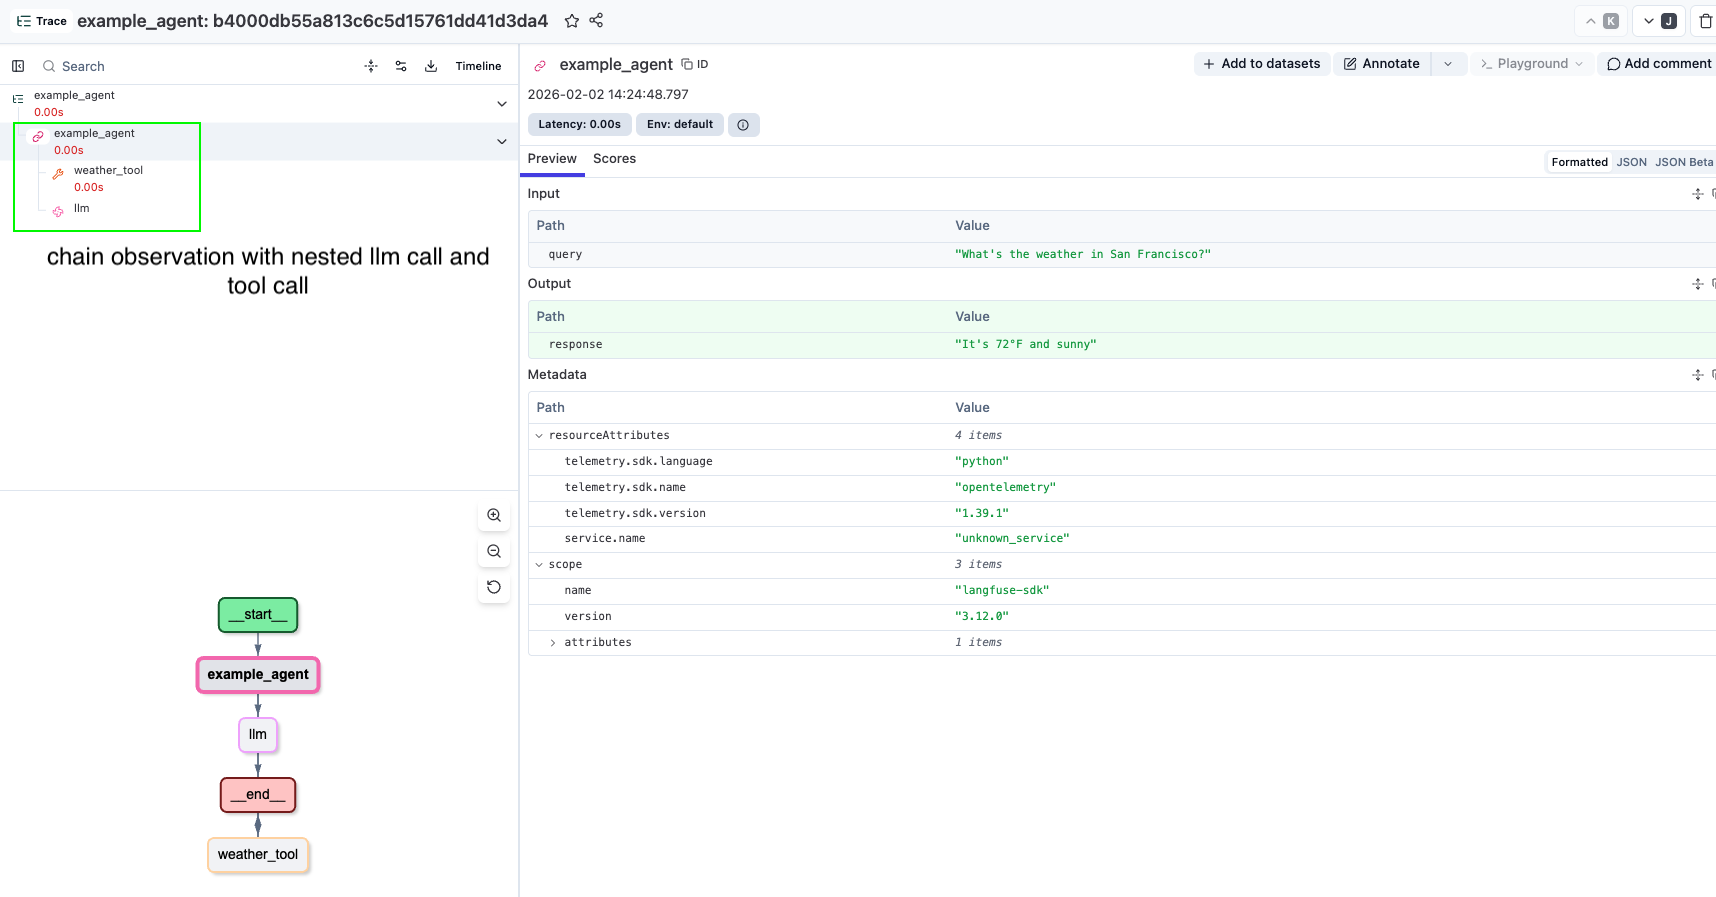

### Managing Langfuse observations for LangGraph events

In [ ]:
class LangfuseObservationTracker:
    """    
    Uses langfuse_client.start_as_current_observation() to create child
    observations. Nesting is automatic through OpenTelemetry context
    propagation — any observation created within the root trace's context
    manager becomes a child of that trace.
    """

    def __init__(self, langfuse_client):
        """
        Initialize the tracker with a Langfuse client.
        
        Args:
            langfuse_client: The Langfuse client instance used to create observations
        """
        self.langfuse_client = langfuse_client

    def track_llm_call(self, name: str, input_messages: Any, output: Any, model: Optional[str] = None):
        """
        Track an LLM call as a Langfuse generation.
        
        A generation is a specialized observation type for AI model interactions.
        It captures the input prompt, output response, and model information.
        
        Args:
            name: Name of the LLM call (e.g., "ChatModel")
            input_messages: The input messages sent to the LLM
            output: The response from the LLM
            model: Optional model name (e.g., "ibm/granite-4-h-small")
        """
        print(f"  Tracking LLM call: {name}")
        
        with self.langfuse_client.start_as_current_observation(
            as_type="generation",
            name=name,
            input=input_messages,
            model=model,
        ) as generation:
            generation.update(output=output)
        return generation

    def track_tool_call(self, name: str, tool_input: Any, tool_output: Any):
        """
        Track a tool execution as a Langfuse tool observation.
        
        A tool observation captures when the agent calls an external tool/function.
        It records what tool was called, with what input, and what it returned.
        
        Args:
            name: Name of the tool (e.g., "get_current_weather")
            tool_input: The input arguments passed to the tool
            tool_output: The result returned by the tool
        """
        print(f"  Tracking tool call: {name}")
        
        with self.langfuse_client.start_as_current_observation(
            as_type="tool",
            name=name,
            input=tool_input,
        ) as tool_obs:
            tool_obs.update(output=tool_output)
        return tool_obs

In [ ]:
def test_event_generator(graph: CompiledStateGraph, user_input: str):
    """
    manual Langfuse tracing from our langgraph graph execution.
    
    Steps:
    1. Create root trace - container for all observations, represents entire agent execution
    2. Stream agent events - capture step-by-step graph node executions
    3. Log observations - LLM calls as "generation", tool calls as "tool"
    4. Flush to Langfuse - ensure all data is sent to server
    """

    user_message = HumanMessage(user_input)
    input_state = State(messages=[user_message])
    session_id = str(uuid.uuid4())

    print(f"User input: {user_input}")
    print(f"Session ID: {session_id}\n")

    print("STEP 1: Creating root trace...")

    with langfuse_client.start_as_current_observation(
        as_type="chain",
        name="Simple_Agent_Trace",
        input={"user_message": user_input},
        metadata={"session_id": session_id}
    ) as trace:
        print(f"Trace created with ID: {trace.trace_id}\n")

        tracker = LangfuseObservationTracker(langfuse_client)

        print("STEP 2: Executing agent and capturing events...\n")

        final_output = None
        llm_call_count = 0
        tool_call_count = 0

        # event is a dict with node_name as key and state update as value
        for event in graph.stream(input_state):
            for node_name, state_update in event.items():
                print(f"Node executed: {node_name}")

                if node_name == "llm":
                    llm_call_count += 1
                    messages = state_update.get("messages", [])
                    if messages:
                        last_message = messages[-1]

                        input_msgs = input_state.get("messages", []) if llm_call_count == 1 else []
                        output_content = last_message.content if hasattr(last_message, "content") else str(last_message)

                        tracker.track_llm_call(
                            name=f"LLM_Call_{llm_call_count}",
                            input_messages=input_msgs,
                            output={"content": output_content},
                            model=model
                        )

                        if hasattr(last_message, "tool_calls") and last_message.tool_calls:
                            print(f"  LLM decided to call {len(last_message.tool_calls)} tool(s)")
                        else:
                            print(f"  LLM generated final response")

                elif node_name == "tools":
                    tool_call_count += 1
                    messages = state_update.get("messages", [])
                    if messages:
                        for msg in messages:
                            if hasattr(msg, "name"):
                                tool_name = msg.name
                                tool_output = msg.content if hasattr(msg, "content") else str(msg)
                                tracker.track_tool_call(
                                    name=tool_name,
                                    tool_input={"call": f"Tool call #{tool_call_count}"},
                                    tool_output={"result": tool_output}
                                )
                                print(f"  Tool '{tool_name}' executed")
                final_output = state_update

        if final_output and "messages" in final_output:
            final_message = final_output["messages"][-1]
            final_response = final_message.content if hasattr(final_message, "content") else str(final_message)
        else:
            final_response = "No response generated"

        print("\nSTEP 4: Finalizing trace...")
        trace.update(output={"final_response": final_response})

    langfuse_client.flush()
    print("Trace data sent to Langfuse\n")

    print("-" * 80)
    print("EXECUTION SUMMARY:")
    print(f"  LLM calls: {llm_call_count}")
    print(f"  Tool calls: {tool_call_count}")
    print(f"  Final response: {final_response[:100]}...")
    print(f"  Trace ID: {trace.trace_id}")
    print(f"  View in Langfuse: {os.environ.get('LANGFUSE_HOST', 'https://cloud.langfuse.com')}/trace/{trace.trace_id}")
    print("=" * 80 + "\n")

    return {
        "session_id": session_id,
        "output": final_response,
        "trace_id": trace.trace_id,
        "llm_calls": llm_call_count,
        "tool_calls": tool_call_count
    }

In [ ]:
user_input = "What is the weather in Miami?"
test_event_generator(graph=graph,user_input=user_input)

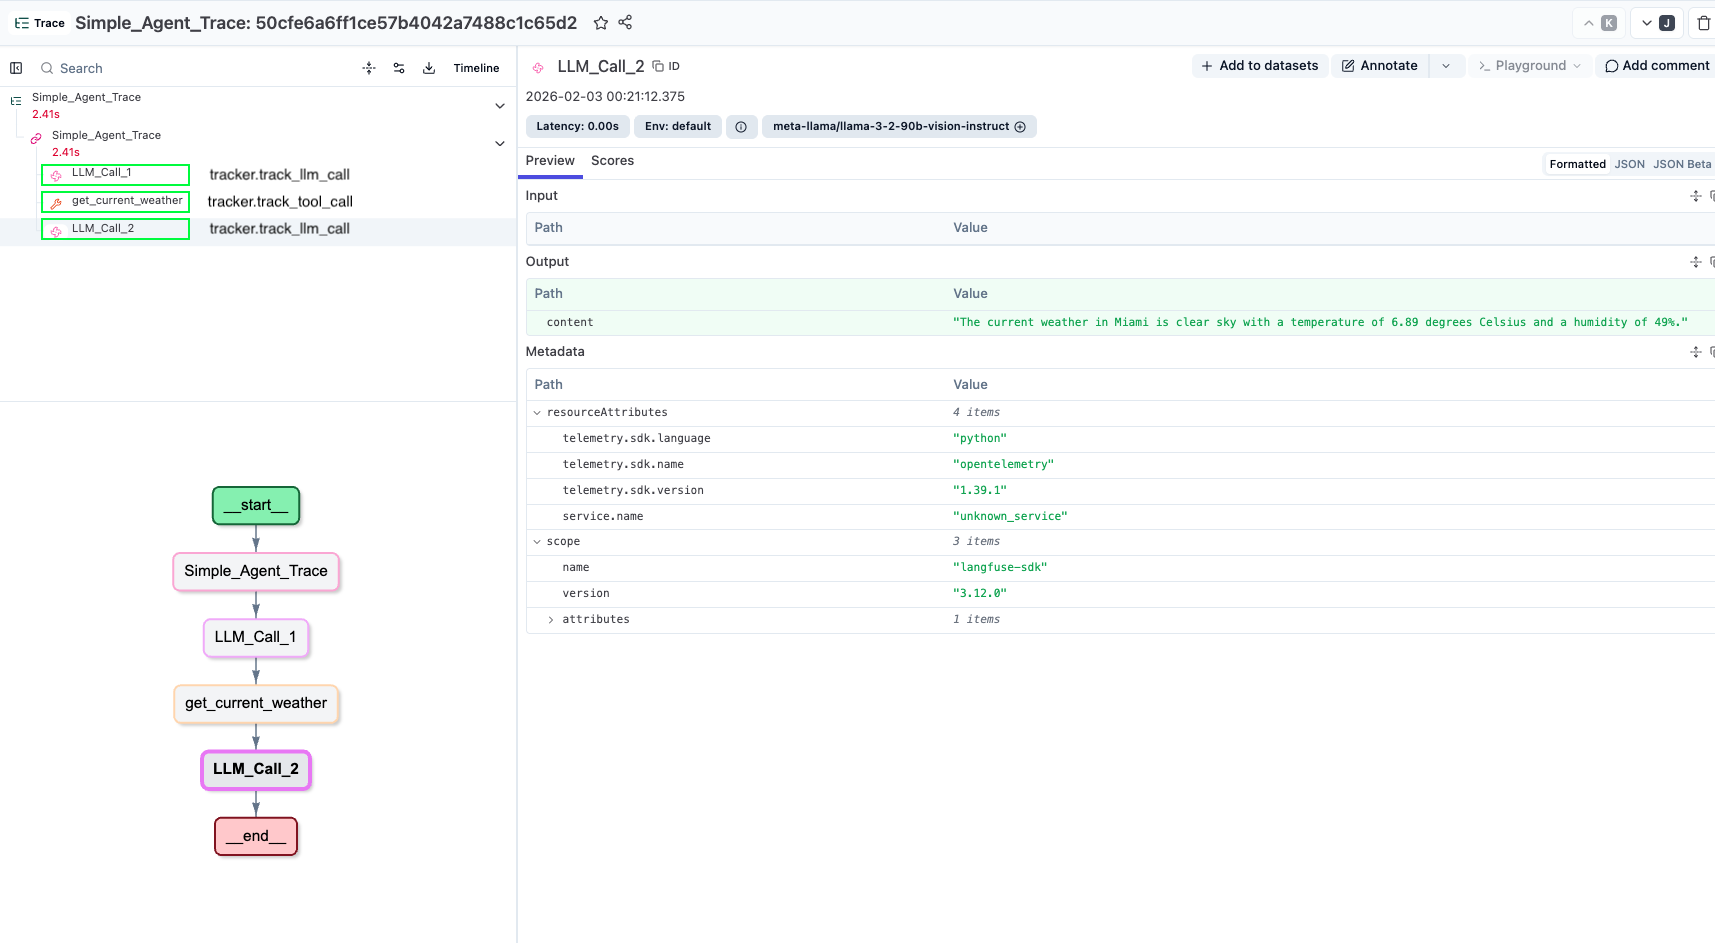